In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode, zscore
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

flatten = lambda l : [item for sublist in l for item in sublist]


In [2]:
def count_missing(df):
    r=dict()
    #missing_data_per_col=list()

    for _c in df.columns:
        r[_c]=dict()
        _sum = df[_c].isna().sum()
        _pct= round(_sum/len(df), 4)
        r[_c]['sum']=_sum
        r[_c]['pct']=_pct
    
    ttl_rows_w_missing = len(df) - len(df.dropna())
    r["__ttl_rows_missing_data__"]=ttl_rows_w_missing
    return(r)

In [3]:
# 1. GOOGLE PLAY STORE
# Use Google Play Store data and clean it.
# Dataset
# https://raw.githubusercontent.com/ammishra08/MachineLearning/master/Datasets/google_playstore_apps.csv

gp_df=pd.read_csv('https://raw.githubusercontent.com/ammishra08/MachineLearning/master/Datasets/google_playstore_apps.csv')
gp_df.sample(10)
gp_df.shape
gp_df.drop_duplicates(inplace=True)
# gp_df.info()

# a) Display missing data (total counts and percentage value)
missing_dict = count_missing(gp_df)
pprint(missing_dict)


{'Android Ver': {'pct': 0.0003, 'sum': 3},
 'App': {'pct': 0.0, 'sum': 0},
 'Category': {'pct': 0.0, 'sum': 0},
 'Content Rating': {'pct': 0.0001, 'sum': 1},
 'Current Ver': {'pct': 0.0008, 'sum': 8},
 'Genres': {'pct': 0.0, 'sum': 0},
 'Installs': {'pct': 0.0, 'sum': 0},
 'Last Updated': {'pct': 0.0, 'sum': 0},
 'Price': {'pct': 0.0, 'sum': 0},
 'Rating': {'pct': 0.1414, 'sum': 1465},
 'Reviews': {'pct': 0.0, 'sum': 0},
 'Size': {'pct': 0.0, 'sum': 0},
 'Type': {'pct': 0.0001, 'sum': 1},
 '__ttl_rows_missing_data__': 1472}


In [4]:
# b) Check for duplicates in the whole dataset
dupes=gp_df.duplicated()#gp_df[gp_df.duplicated()]

# c) Remove Duplicates
display("shape before drop_duplicates: ", gp_df.shape)
gp_df.drop_duplicates(inplace=True)
display("shape after drop_duplicates: ", gp_df.shape)


'shape before drop_duplicates: '

(10358, 13)

'shape after drop_duplicates: '

(10358, 13)

In [5]:
# d) Handle 'Varies with device' from Size
# e) Prepare & clean “Size” column” by unwanted suffix values


# display(gp_df['Size'].unique())

def size_to_float(s):
    o=s
    # let's describe everything by MB
    f = np.nan
    if s == 'Varies with device':
        return(np.nan)
    
    s = str(s).lower().replace(",", "")
    
    if s[-1] =='m':
        f = float(s[:-1])
        
    if s[-1] =='k':
        f = float(s[:-1])*10**-3
        
    if s[-1] == '+':
        return(size_to_float(s.replace("+", "m")))
    if type(f) in [float]:
        f=round(f, 3)
    if 0:
        print(f"{size_to_float.__name__} received {o}, returned {f}")
    if f>100:
        f=100
    return(f)
  
size_to_float(None)
assert size_to_float('920k') == (920*10**-3)
assert size_to_float('442k') == (442*10**-3)
assert size_to_float('2.8M') == (2.8)
assert size_to_float('2.8M') == (2.8)
    
gp_df['Size_M'] = gp_df['Size'].apply(size_to_float)
display('nans before fillna:', gp_df['Size_M'].isna().sum())
display(f"replacing nans in Size_M with median: {np.nanmedian(gp_df['Size_M'])}")
gp_df['Size_M'].fillna(np.nanmedian(gp_df['Size_M']), inplace=True)
display('nans after fillna:', gp_df['Size_M'].isna().sum())


'nans before fillna:'

1526

'replacing nans in Size_M with median: 13.0'

'nans after fillna:'

0

In [6]:
# f) Removing '+' and ',' from Installs

def installs_to_int(s):
    stripchars= [',', '+',]
    special_cases=["Free"]
    
    if s in special_cases:
        return(np.nan)
    
    for _c in stripchars:
        s=s.replace(_c, "")
    
    i=int(s)
    
    return(i)
    
gp_df['Installs_i'] =  gp_df['Installs'].apply(installs_to_int)
gp_df['Installs_i'].isna().sum()
gp_df['Installs_i'].fillna(np.nanmedian(gp_df['Installs_i']), inplace=True)

In [7]:
# g) Cleaning “Android Ver” by removing unwanted strings
def clean_ver(s):
    """Assume all version numbers are forewards compatible if not specified by range"""
    if not type(s) == str:
        return(s)
    stopwords = [" and up"]
    for sw in stopwords:
        s=s.replace(sw, "")
    return(s)

# [clean_ver(s) for s in gp_df['Android Ver'].unique()]
gp_df['Ver_cleaned'] = gp_df['Android Ver'].apply(clean_ver)

gp_df['Ver_cleaned'].unique()

array(['4.0.3', '4.2', '4.4', '2.3', '3.0', '4.1', '4.0', '2.3.3',
       'Varies with device', '2.2', '5.0', '6.0', '1.6', '1.5', '2.1',
       '7.0', '5.1', '4.3', '4.0.3 - 7.1.1', '2.0', '3.2', '4.4W', '7.1',
       '7.0 - 7.1.1', '8.0', '5.0 - 8.0', '3.1', '2.0.1', '4.1 - 7.1.1',
       nan, '5.0 - 6.0', '1.0', '2.2 - 7.1.1', '5.0 - 7.1.1'],
      dtype=object)

In [8]:
# h) Clean column Price

def clean_price(s):
    stripchars=['$',]
    special_cases=["Everyone"]
    try:
        if s in special_cases:
            return(np.nan)
        for sc in stripchars:
            s=s.replace(sc, '')
        i=np.double(s) # https://numpy.org/devdocs/reference/arrays.scalars.html#numpy.double
        return(i)
    except ValueError as e:
        print(f"{e}, type(e) inside {clean_price.__name__}")
        return(s)
    
[clean_price(s) for s in gp_df['Price'].unique()]

gp_df['Price_f'] = gp_df['Price'].apply(clean_price)

display(gp_df['Price_f'].describe(), np.nanmedian(gp_df['Price_f']))

count    10357.000000
mean         1.030800
std         16.278625
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        400.000000
Name: Price_f, dtype: float64

0.0

In [9]:
# i) Convert Installs, Size, Android Ver, Price to all numerical

#LATEST_ANDROID = 11.0 # https://en.wikipedia.org/wiki/Android_version_history#Android_11_(API_30)
LATEST_ANDROID = 7.11

#'4.0.3' -> 4.03?
#'2.3.3' -> 2.33?
#'4.4W'  -> 4.4? 4.444? # https://stackoverflow.com/questions/28170345/what-exactly-is-android-4-4w-vs-4-4-and-what-about-5-0-1

def version_to_float(s):
    from string import ascii_letters
    if s == 'Varies with device':
        return np.nan
    if not s.isnumeric():
        for ltr in ascii_letters:
            s=s.replace(ltr, "")
    if s.count('.')>1:
        first_dot_ix=s.find('.')
        major=s[:first_dot_ix+1]
        minor=s[first_dot_ix+1:]
        minor=minor.replace('.', '')
        s=major+minor
    f=np.double(s)
    return(f)

assert version_to_float('4.0.3')==4.03
assert version_to_float('2.2.3')==2.23
assert version_to_float('7.1.1')==7.11
assert version_to_float('4.4W')==4.4

def version_range_s_to_rng(s):
    l=s.split(" - ")
    start=version_to_float(l[0])
    stop=version_to_float(l[1])
    r=(start,stop)
    return(r)

assert version_range_s_to_rng('5.0 - 7.1.1') == (5.0, 7.11)
assert version_range_s_to_rng('2.2 - 7.1.1') == (2.2, 7.11)
assert version_range_s_to_rng('7.0 - 7.1.1') == (7.0, 7.11)


def version_range_decider(s):
    try:
        if s == 'Varies with device':
            return np.nan
        if s in [np.nan]:
            return(s)
        if ' - ' in s:
            return version_range_s_to_rng(s)
        return(version_to_float(s), LATEST_ANDROID)
    except TypeError as e:
        e_str=f"{e}, {type(e)} inside range_decider({s})"
        #print(e_str)
        return(e_str)

gp_df['Ver_cleaned'] = gp_df['Ver_cleaned'].apply(version_range_decider)
gp_df['Ver_cleaned'].unique()





array([(4.03, 7.11), (4.2, 7.11), (4.4, 7.11), (2.3, 7.11), (3.0, 7.11),
       (4.1, 7.11), (4.0, 7.11), (2.33, 7.11), nan, (2.2, 7.11),
       (5.0, 7.11), (6.0, 7.11), (1.6, 7.11), (1.5, 7.11), (2.1, 7.11),
       (7.0, 7.11), (5.1, 7.11), (4.3, 7.11), (2.0, 7.11), (3.2, 7.11),
       (7.1, 7.11), (8.0, 7.11), (5.0, 8.0), (3.1, 7.11), (2.01, 7.11),
       (5.0, 6.0), (1.0, 7.11)], dtype=object)

In [10]:
# j) Using a delimiter separate Genres, create a df using crosstab and visualize it using
# stacked bar/histogram. 
"I tried crosstab but I couldn't get it to work."

"I tried crosstab but I couldn't get it to work."

In [11]:
a_f= lambda g0: tuple(g0.split(';'))
# x= set(gp_df['Genres'].apply(a_f).unique())
x= gp_df['Genres'].apply(a_f).unique()
x1= sorted(list((set(flatten(x)))))
x1 # # flattened columns!
ct_df= pd.crosstab(x1, gp_df['Genres'])

display(x1)
display(ct_df)

# genres_parsed = sorted(list(set(flatten([g.split(';') for g in gp_df['Genres'].unique()]))))
#ct=pd.crosstab(gp_df['Genres'].index, gp_df['Genres']) # works? but not to spec.
#ct=pd.crosstab(gp_df['Genres'], genres_parsed,) #  # works? but not to spec.

['Action',
 'Action & Adventure',
 'Adventure',
 'Arcade',
 'Art & Design',
 'Auto & Vehicles',
 'Beauty',
 'Board',
 'Books & Reference',
 'Brain Games',
 'Business',
 'Card',
 'Casino',
 'Casual',
 'Comics',
 'Communication',
 'Creativity',
 'Dating',
 'Education',
 'Educational',
 'Entertainment',
 'Events',
 'February 11, 2018',
 'Finance',
 'Food & Drink',
 'Health & Fitness',
 'House & Home',
 'Libraries & Demo',
 'Lifestyle',
 'Maps & Navigation',
 'Medical',
 'Music',
 'Music & Audio',
 'Music & Video',
 'News & Magazines',
 'Parenting',
 'Personalization',
 'Photography',
 'Pretend Play',
 'Productivity',
 'Puzzle',
 'Racing',
 'Role Playing',
 'Shopping',
 'Simulation',
 'Social',
 'Sports',
 'Strategy',
 'Tools',
 'Travel & Local',
 'Trivia',
 'Video Players & Editors',
 'Weather',
 'Word']

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Genres,Action,Action;Action & Adventure,Adventure,Adventure;Action & Adventure,Adventure;Brain Games,Adventure;Education,Arcade,Arcade;Action & Adventure,Arcade;Pretend Play,Art & Design,...,Tools;Education,Travel & Local,Travel & Local;Action & Adventure,Trivia,Trivia;Education,Video Players & Editors,Video Players & Editors;Creativity,Video Players & Editors;Music & Video,Weather,Word
row_0,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,row_10,row_11,row_12,row_13,row_14,row_15,row_16,row_17,row_18,row_19,row_20,row_21,row_22,row_23,row_24,row_25,row_26,row_27,row_28,row_29,row_30,row_31,row_32,row_33,row_34,row_35,row_36,row_37,row_38,row_39,row_40,row_41,row_42,row_43,row_44,row_45,row_46,row_47,row_48,row_49,row_50,row_51,row_52,row_53,,,,,,,,,,,,,,,,,,,,,
Action,Action & Adventure,Adventure,Arcade,Art & Design,Auto & Vehicles,Beauty,Board,Books & Reference,Brain Games,Business,Card,Casino,Casual,Comics,Communication,Creativity,Dating,Education,Educational,Entertainment,Events,"February 11, 2018",Finance,Food & Drink,Health & Fitness,House & Home,Libraries & Demo,Lifestyle,Maps & Navigation,Medical,Music,Music & Audio,Music & Video,News & Magazines,Parenting,Personalization,Photography,Pretend Play,Productivity,Puzzle,Racing,Role Playing,Shopping,Simulation,Social,Sports,Strategy,Tools,Travel & Local,Trivia,Video Players & Editors,Weather,Word,356,15,75,13,1,2,218,15,1,58,...,1,236,1,38,1,173,2,3,82,28


In [12]:
genre_df = pd.DataFrame(gp_df[['Genres','Installs', 'App', 'Type']])
genre_df['Genres_l']=genre_df['Genres'].apply(lambda r: r.split(';'))

for g in x1:
    genre_df[g] = genre_df['Genres_l'].apply(lambda c: g in c)



In [13]:
keys = [c for c in genre_df.columns if c not in ["Genres", "Genres_l", "Installs", "February 11, 2018", 'App']]
genre_df[keys].sum().sort_values()#ascending=False).plot.hist(x=genre_df[keys])

Music & Audio                1
Music                       24
Word                        28
Creativity                  37
Trivia                      39
Casino                      39
Music & Video               41
Card                        51
Beauty                      53
Parenting                   60
Comics                      60
Board                       63
Events                      64
Art & Design                69
Brain Games                 69
House & Home                80
Pretend Play                80
Weather                     82
Libraries & Demo            85
Auto & Vehicles             85
Adventure                   91
Educational                106
Strategy                   109
Racing                     119
Role Playing               120
Food & Drink               124
Action & Adventure         128
Maps & Navigation          137
Puzzle                     162
Video Players & Editors    178
Dating                     196
Simulation                 216
Shopping

<AxesSubplot:>

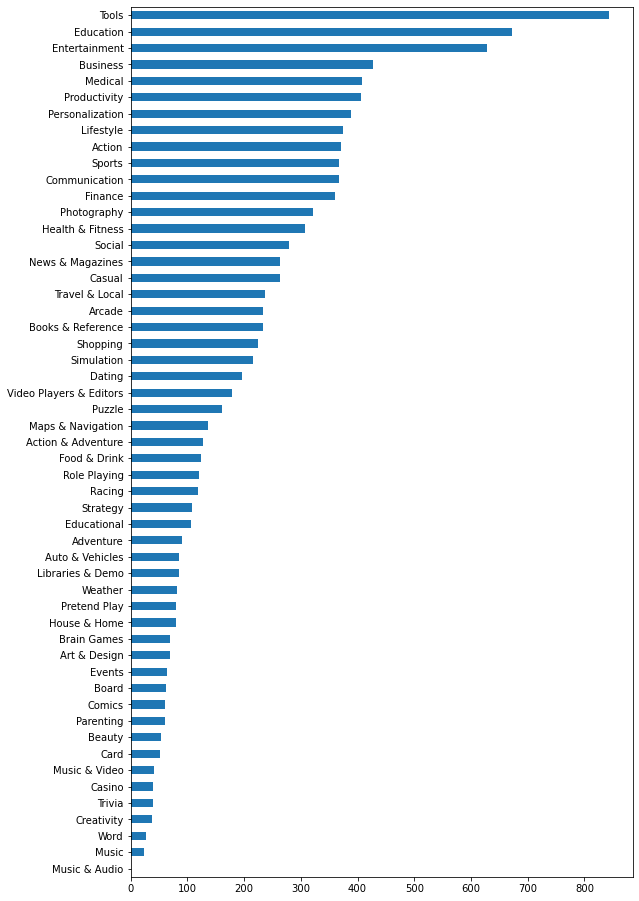

In [14]:
genre_df[keys].sum().sort_values(ascending=True).plot.barh(x=genre_df[keys], figsize=(9,16))

In [15]:
# 2. DATA VISUALIZATION
# Dataset
# google_playstore_app.csv (same as the first problem) and playstore_user_reviews.csv
# 1) Clean the data: Remove redundant data, Drop NA/ nulls, make new features, Rename columns.

reviews_data_path = r'C:\Users\emmam\Documents\nlb\data\playstore_user_reviews.csv'
ur_df=pd.read_csv(reviews_data_path)
display(ur_df.sample(10))
ur_df.isna().sum()



,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
8035,Anthem Anywhere,The home screen totally different description....,Neutral,0.000000,0.600000
62903,Home Workout for Men - Bodybuilding,That excellent according vision another I can'...,Positive,0.933333,0.683333
63476,Horoscopes – Daily Zodiac Horoscope and Astrology,Constantly shows error,Neutral,0.000000,0.333333
22361,Calorie Counter by FatSecret,NaN,NaN,NaN,NaN
62059,Hill Climb Racing 2,I love game I play I'm bored I specialy love p...,Positive,0.025000,0.650000
7019,Ancestry,"This worked great, recent update glitches, jum...",Positive,0.400000,0.500000
20103,"CM Launcher 3D - Theme, Wallpapers, Efficient",NaN,NaN,NaN,NaN
26166,Chime - Mobile Banking,NaN,NaN,NaN,NaN
25599,ChefTap Recipes & Grocery List,NaN,NaN,NaN,NaN
51352,"GO SMS Pro - Messenger, Free Themes, Emoji",I bought year subscription pro version. I love...,Positive,0.450000,0.500000


App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [16]:
#nans

def display_nan_info(df):
    [display(f"{_c}, {df[_c].isna().sum()/df[_c].__len__()}") for _c in df.columns]

display_nan_info(ur_df)
display(f"ur_df.isna().sum()", ur_df.isna().sum())
display(f"ur_df shape before dropna: {ur_df.shape}")
ur_df.dropna(axis=0, inplace=True)
display(f"ur_df shape after dropna: {ur_df.shape}")
display(f"ur_df.isna().sum()", ur_df.isna().sum())


'App, 0.0'

'Translated_Review, 0.417886305311455'

'Sentiment, 0.4178085387666226'

'Sentiment_Polarity, 0.4178085387666226'

'Sentiment_Subjectivity, 0.4178085387666226'

'ur_df.isna().sum()'

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

'ur_df shape before dropna: (64295, 5)'

'ur_df shape after dropna: (37427, 5)'

'ur_df.isna().sum()'

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

In [17]:
ur_df.info()
ur_df['Sentiment_Subjectivity'].apply(np.double, inplace=True)
ur_df['Sentiment_Polarity'].apply(np.double, inplace=True)
ur_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37427 entries, 0 to 64230
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     37427 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37427 non-null  object 
 3   Sentiment_Polarity      37427 non-null  float64
 4   Sentiment_Subjectivity  37427 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37427 entries, 0 to 64230
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     37427 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37427 non-null  object 
 3   Sentiment_Polarity      37427 non-null  float64
 4   Sentiment_Subjectivity  37427 non-null

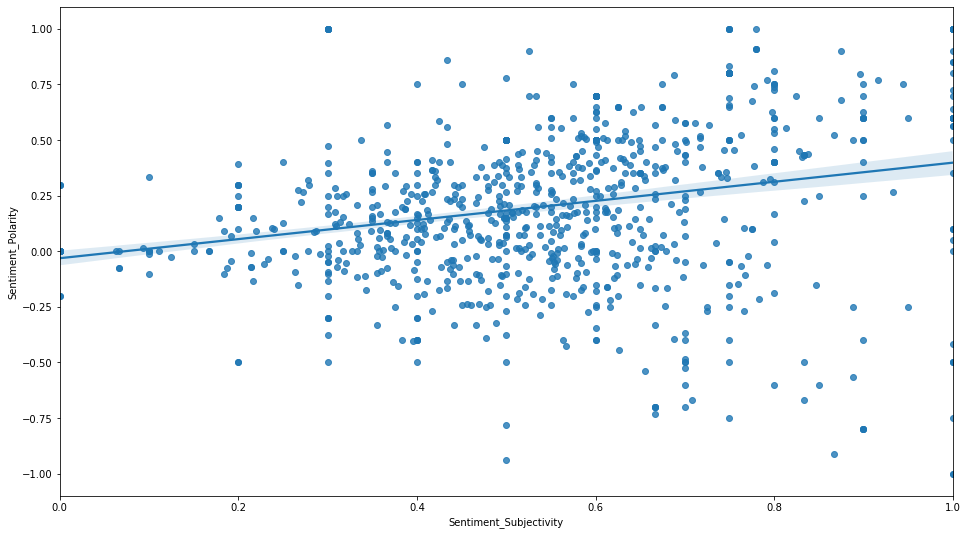

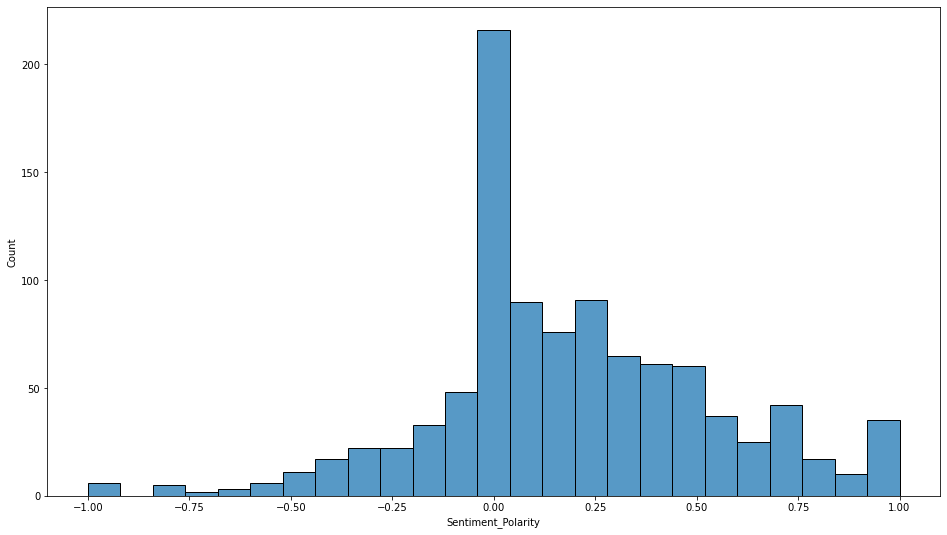

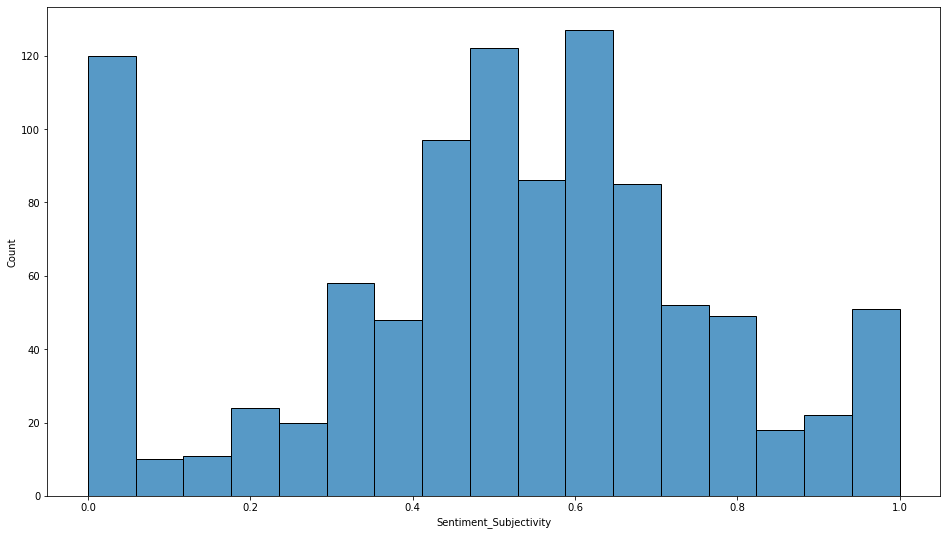

In [18]:
# 2) Explore the Data (with data visualization):

ur_df.columns
#ur_df.plot.scatter('Sentiment_Subjectivity', 'Sentiment_Polarity')

plt.figure(figsize=(16,9))

ax0= sns.regplot(x='Sentiment_Subjectivity', y='Sentiment_Polarity', data=ur_df.sample(10**3), )
plt.show()


plt.figure(figsize=(16,9))
ax1 = sns.histplot(x='Sentiment_Polarity', data=ur_df.sample(10**3), )
plt.show()

plt.figure(figsize=(16,9))
ax1 = sns.histplot(x='Sentiment_Subjectivity', data=ur_df.sample(10**3), )
plt.show()



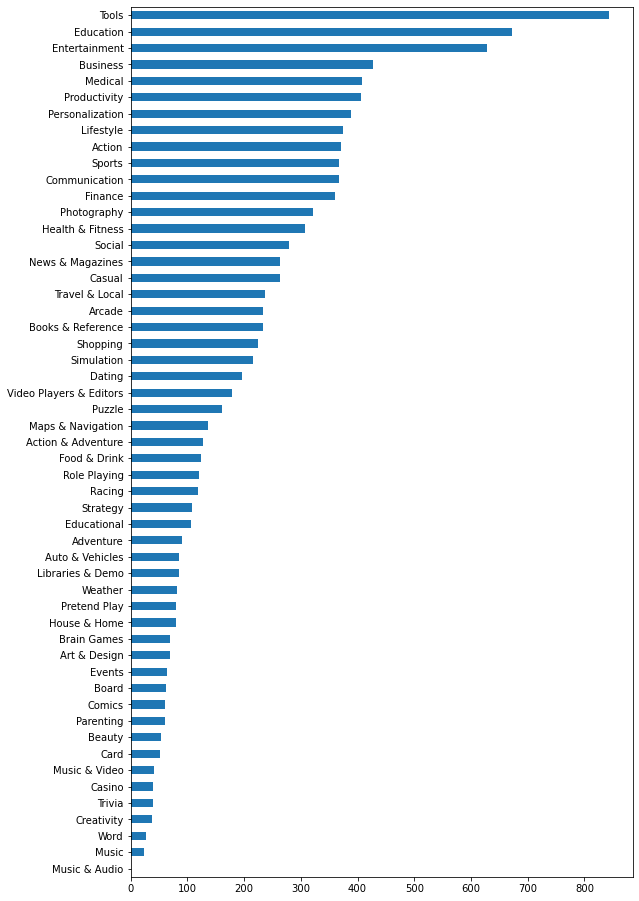

In [19]:
# a) Visualizing Distribution of the useful features: Total Apps in Each Category, Content Ratings Distribution

total_apps_in_each_category_ax = genre_df[keys].sum().sort_values(ascending=True).plot.barh(x=genre_df[keys], figsize=(9,16))
plt.show()


In [20]:
# b) Number of Free vs Paid Apps

no_free = gp_df.loc[gp_df['Price_f'] ==0]['App'].count()
no_paid = gp_df.loc[gp_df['Price_f'] > 0]['App'].count()
pct_paid ="{:.2%}".format(no_paid/no_free)
display(
f"Number of free apps: {no_free}", # free apps
f"Number of paid apps: {no_paid}", # free apps
f"Percent of paid apps: {pct_paid}",
)

'Number of free apps: 9592'

'Number of paid apps: 765'

'Percent of paid apps: 7.98%'

In [21]:
def sort_scatter_on_val(df, col):
    s= pd.Series(df[col].unique()).sort_values()
    #s=s[:-1]
    s= s.reset_index()
    s= s.drop('index', axis=1) # drop original index
    s= s.reset_index()
    s.columns = ['ix', col]
    #display(s, type(s))
    return(
    s.plot.scatter(x='ix', y=col,figsize=(15,10))
    )

<AxesSubplot:xlabel='ix', ylabel='Size_M'>

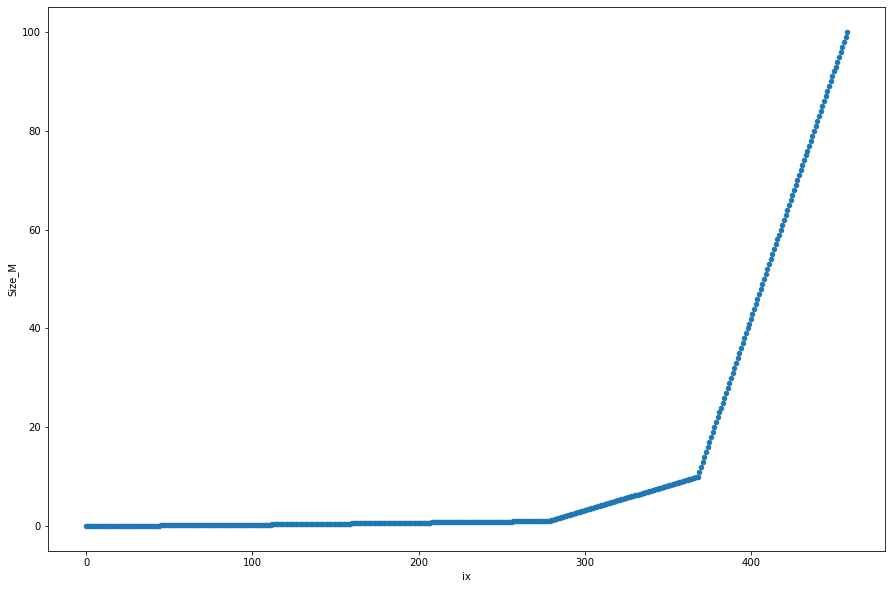

In [22]:
# c) Size Range for free and paid Apps
sort_scatter_on_val(gp_df, 'Size_M')



<AxesSubplot:xlabel='ix', ylabel='Price_f'>

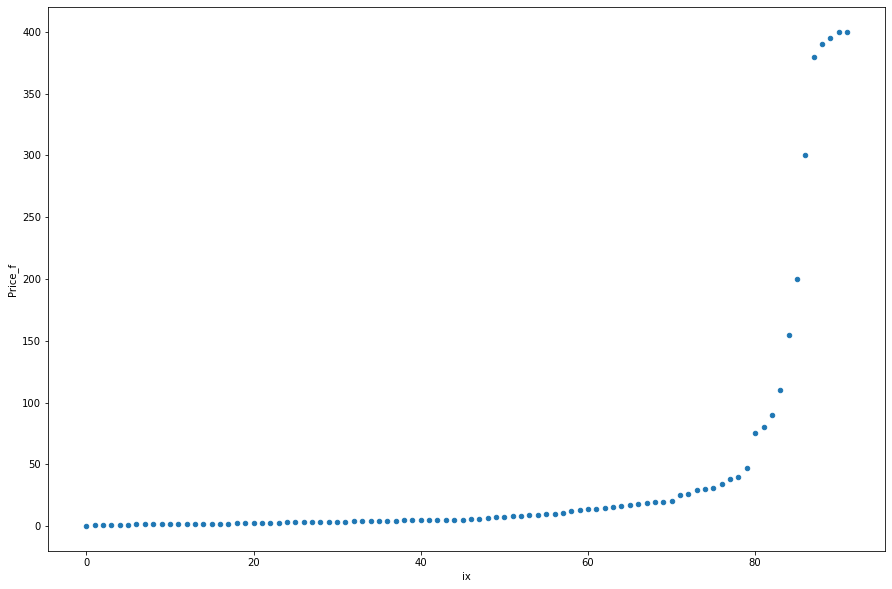

In [23]:
# d) Visualizing Price of Number of apps for every price
# gp_df['Price_f'].plot.hist(bins=20)
sort_scatter_on_val(gp_df, 'Price_f')

In [24]:
# e) Total installs pie chart, Rating Distribution – pie and bar
gp_df.columns
gp_df['Installs'].unique()
def clean_installs(s):
    stripchars = ['+', ',']
    if type(s) in [float, int]:
        return(int(s))
    if s == 'Free':
        return(0)
    for _c in stripchars:
        s = s.replace(_c , '')
    i = int(s)
    return(i)

    
gp_df['Installs_i'] = gp_df['Installs_i'].apply(clean_installs)



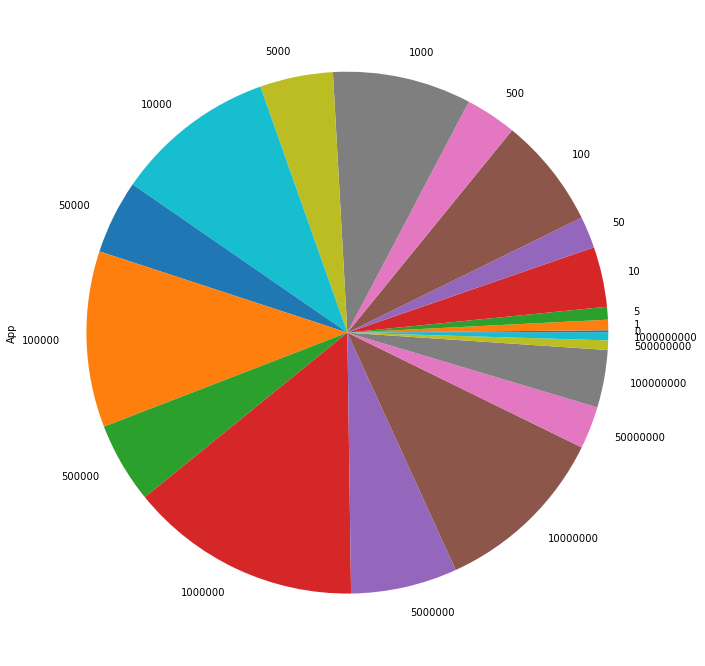

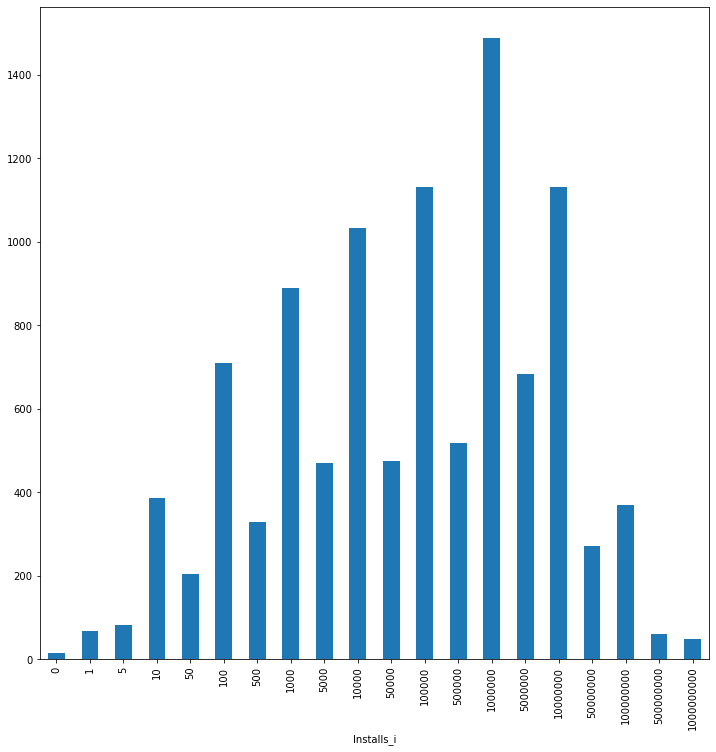

In [25]:
# gp_df.plot.pie(y='Installs_i')
installs_counts= gp_df.groupby('Installs_i')['App'].count()

installs_counts.plot.pie(figsize=(12,12))
plt.show()

installs_counts.plot.bar(figsize=(12,12))
plt.show()

# installs_counts.plot.hist(x='Installs_i', figsize=(12,12), cumulative=True)
# plt.show()

In [26]:
# f) CDF (Cumulative Distributive Function), PDF (Probability Density Function) – Installs, Ratings
from scipy.stats import norm

# g) Rating vs Content Rating
gp_df['Content Rating'].unique()

def get_sentiment_mean(app):
    return(
    np.nanmean(ur_df.loc[ur_df['App']==app]['Sentiment_Polarity'])
    )

gp_df['Mean_sentiment']=gp_df['App'].apply(get_sentiment_mean)




<ipython-input-26-1b8f5d7964bc>:9: RuntimeWarning: Mean of empty slice
  np.nanmean(ur_df.loc[ur_df['App']==app]['Sentiment_Polarity'])


<AxesSubplot:xlabel='Content Rating'>

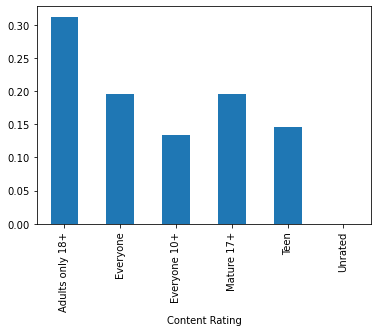

In [27]:
gp_df.groupby('Content Rating')['Mean_sentiment'].mean().plot.bar()

<AxesSubplot:xlabel='Content Rating'>

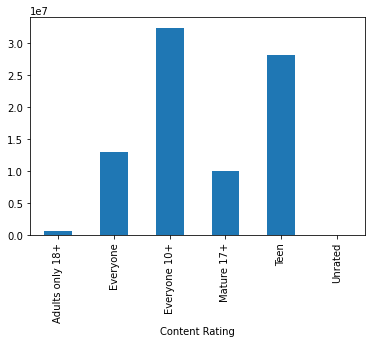

In [28]:
# h) TOP CATEGORIES out of most installed FREE APPS in the dataframe obtained above.

gp_df.loc[gp_df['Type']=="Free"].groupby('Content Rating')['Installs_i'].mean().plot.bar()


In [29]:
# i) TOP GENRES out of all the highest installed FREE APPS

# genre_df.loc[gp_df['Type']=="Free"]
# def typegetter(a):
#     try:
#         t=gp_df.loc[gp_df['App']==a]['Type']
#         return(t)
#     except Exception as e:
#         display(f"{e}, {type(e)}, inside typegetter({a})")
    
# genre_df['Type'] = genre_df['App'].apply(typegetter)

#keys = [c for c in genre_df.columns if c not in ["Genres", "Genres_l", "Installs", "February 11, 2018", 'App']]





In [30]:
genre_df['Type'].unique()

array(['Free', 'Paid', nan, '0'], dtype=object)

<AxesSubplot:>

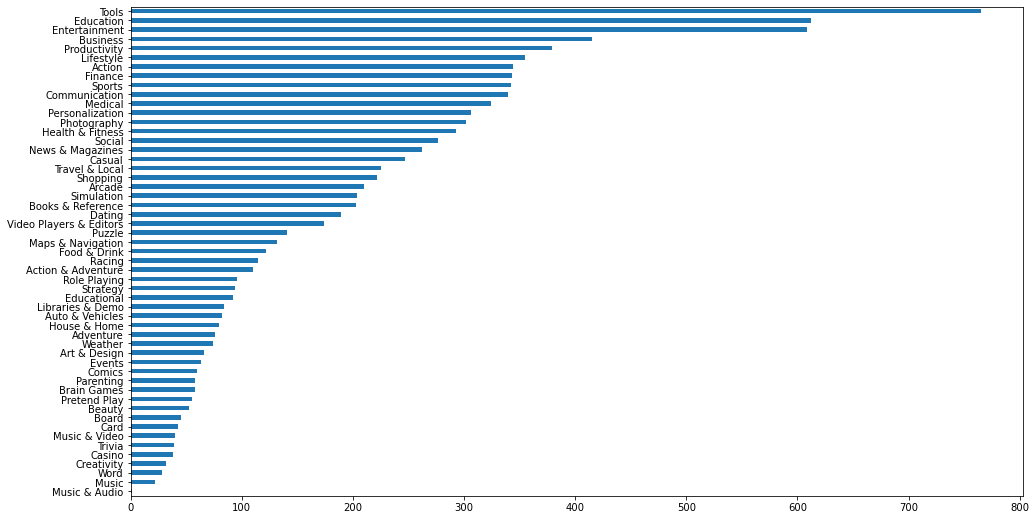

In [31]:
q0= genre_df.loc[genre_df['Type']=="Free"][keys].sum()#.plot.barh(figsize=(9,16))
q0=q0[1:].sort_values()
q0.plot.barh(figsize=(16,9))

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_M,Installs_i,Ver_cleaned,Price_f,Mean_sentiment
198,Google Primer,BUSINESS,4.4,62272,18M,"10,000,000+",Free,0,Everyone,Business,"June 26, 2018",3.550.2,4.1 and up,18.0,10000000,"(4.1, 7.11)",0.0,0.750000
812,HomeWork,EDUCATION,4.3,16195,5.2M,"1,000,000+",Free,0,Everyone,Education,"September 20, 2016",8.5.2,4.0 and up,5.2,1000000,"(4.0, 7.11)",0.0,1.000000
1035,Goldstar: Live Event Tickets,EVENTS,4.5,1953,Varies with device,"100,000+",Free,0,Teen,Events,"August 1, 2018",Varies with device,Varies with device,13.0,100000,NaN,0.0,0.549266
1068,BBVA Spain,FINANCE,4.2,36746,Varies with device,"5,000,000+",Free,0,Everyone,Finance,"July 24, 2018",Varies with device,Varies with device,13.0,5000000,NaN,0.0,0.515086
1268,Home Workout for Men - Bodybuilding,HEALTH_AND_FITNESS,4.8,12705,15M,"1,000,000+",Free,0,Everyone,Health & Fitness,"July 10, 2018",1.0.2,4.0 and up,15.0,1000000,"(4.0, 7.11)",0.0,0.523450
1316,Daily Workouts - Exercise Fitness Routine Trainer,HEALTH_AND_FITNESS,4.4,134195,Varies with device,"10,000,000+",Free,0,Everyone,Health & Fitness,"June 14, 2018",Varies with device,Varies with device,13.0,10000000,NaN,0.0,0.800000
1353,Best Ovulation Tracker Fertility Calendar App ...,HEALTH_AND_FITNESS,4.6,56145,23M,"1,000,000+",Free,0,Everyone,Health & Fitness,"August 1, 2018",7.3.4-play,5.0 and up,23.0,1000000,"(5.0, 7.11)",0.0,0.595313
1354,"Eve Period Tracker - Love, Sex & Relationships...",HEALTH_AND_FITNESS,4.6,20326,28M,"1,000,000+",Free,0,Teen,Health & Fitness,"August 4, 2018",2.9.18,4.1 and up,28.0,1000000,"(4.1, 7.11)",0.0,0.505037
1646,Bed Time Fan - White Noise Sleep Sounds,LIFESTYLE,4.5,10097,7.5M,"500,000+",Free,0,Everyone,Lifestyle,"April 26, 2018",1.2,4.0 and up,7.5,500000,"(4.0, 7.11)",0.0,0.781250
2892,Cameringo Lite. Filters Camera,PHOTOGRAPHY,4.2,140917,5.7M,"10,000,000+",Free,0,Everyone,Photography,"June 11, 2018",2.2.93,4.0 and up,5.7,10000000,"(4.0, 7.11)",0.0,0.770269


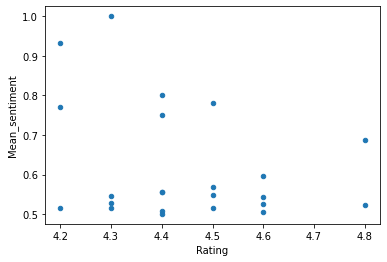

In [32]:
# j) Which are the best Apps on App Store?

#gp_df.sort_values('Mean_sentiment', ascending=False)[:25]#['Mean_sentiment']

best_rows_by_rating_sentiment = gp_df.loc[(gp_df['Mean_sentiment'] > .5) & (gp_df['Rating'] > gp_df['Rating'].mean())]

best_rows_by_rating_sentiment.plot.scatter(x='Rating', y='Mean_sentiment')

display(best_rows_by_rating_sentiment)

In [33]:
# k) Which Category has more likeable Apps?

best_cat_by_rating_sentiment = gp_df.loc[(gp_df['Mean_sentiment'] > .5) & (gp_df['Rating'] > gp_df['Rating'].mean())].groupby('Category')['App'].count()
display(best_cat_by_rating_sentiment.sort_values(ascending=False))


Category
HEALTH_AND_FITNESS     4
TOOLS                  3
PERSONALIZATION        3
SPORTS                 2
TRAVEL_AND_LOCAL       1
PRODUCTIVITY           1
PHOTOGRAPHY            1
NEWS_AND_MAGAZINES     1
MAPS_AND_NAVIGATION    1
LIFESTYLE              1
FINANCE                1
FAMILY                 1
EVENTS                 1
EDUCATION              1
BUSINESS               1
Name: App, dtype: int64

In [34]:
# 3. INDIAN FOOD

# 1) Clean the data (Remove redundant data, Drop NA/ nulls, make new features, Rename
# columns, etc.)
# 2) Explore the Data (with data visualization):
# a) Count of dishes across the different states of India
# b) Let's see how the flavor profile looks like for the different regions in India.
# c) What is the percentage distribution of Vegetarian and Non-Vegetarian dishes?
# d) Visualize the time required to cook the Vegetarian and Non-Vegetarian food items
# e) What all courses do the food items belong to as per the different states
# f) What are dishes with most ingredients?
# g) Display Preparation Time and Cooking Time Distribution using Boxplot
# h) Count state - wise dishes of each Zone

In [35]:
path_indian_food = r'C:\Users\emmam\Documents\nlb\data\indian_food.csv'
if_df = pd.read_csv(path_indian_food)
if_df

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45,25,sweet,dessert,West Bengal,East
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80,30,sweet,dessert,Rajasthan,West
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15,60,sweet,dessert,Punjab,North
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15,30,sweet,dessert,Rajasthan,West
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15,40,sweet,dessert,West Bengal,East
...,...,...,...,...,...,...,...,...,...
250,Til Pitha,"Glutinous rice, black sesame seeds, gur",vegetarian,5,30,sweet,dessert,Assam,North East
251,Bebinca,"Coconut milk, egg yolks, clarified butter, all...",vegetarian,20,60,sweet,dessert,Goa,West
252,Shufta,"Cottage cheese, dry dates, dried rose petals, ...",vegetarian,-1,-1,sweet,dessert,Jammu & Kashmir,North
253,Mawa Bati,"Milk powder, dry fruits, arrowroot powder, all...",vegetarian,20,45,sweet,dessert,Madhya Pradesh,Central


In [36]:
# 1) Clean the data (Remove redundant data, Drop NA/ nulls, make new features, Rename
# columns, etc.)
display(

if_df.isna().sum(),
if_df.dropna(axis=0, inplace=True),
if_df.isna().sum(),

if_df.shape,
if_df.drop_duplicates(inplace=True),
if_df.shape,
if_df.info(),
)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 0 to 254
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            254 non-null    object
 1   ingredients     254 non-null    object
 2   diet            254 non-null    object
 3   prep_time       254 non-null    int64 
 4   cook_time       254 non-null    int64 
 5   flavor_profile  254 non-null    object
 6   course          254 non-null    object
 7   state           254 non-null    object
 8   region          254 non-null    object
dtypes: int64(2), object(7)
memory usage: 19.8+ KB


name              0
ingredients       0
diet              0
prep_time         0
cook_time         0
flavor_profile    0
course            0
state             0
region            1
dtype: int64

None

name              0
ingredients       0
diet              0
prep_time         0
cook_time         0
flavor_profile    0
course            0
state             0
region            0
dtype: int64

(254, 9)

None

(254, 9)

None

In [37]:
a_f = lambda g0: tuple(g0.split(', '))

ingredients_lst = if_df['ingredients'].apply(a_f).unique()
ingredients_lst = sorted(list((set(flatten(ingredients_lst)))))
ingredients_lst = sorted(list(set([s.strip().lower() for s in ingredients_lst])))
ingredients_lst

if_df['ingredients_l']=if_df['ingredients'].apply(lambda s: [ss.strip().lower() for ss in s.split(', ')])
if_df['ingredients_l']

for ii in ingredients_lst:
    if_df[ii] = if_df['ingredients_l'].apply(lambda c: ii in c)
    
    
if_df.columns


Index(['name', 'ingredients', 'diet', 'prep_time', 'cook_time',
       'flavor_profile', 'course', 'state', 'region', 'ingredients_l',
       ...
       'whole urad dal', 'whole wheat bread', 'whole wheat flour',
       'whole wheat rava', 'wild mushrooms', 'wine vinegar',
       'yellow moong daal', 'yellow mustard', 'yoghurt', 'yogurt'],
      dtype='object', length=373)

<AxesSubplot:xlabel='region'>

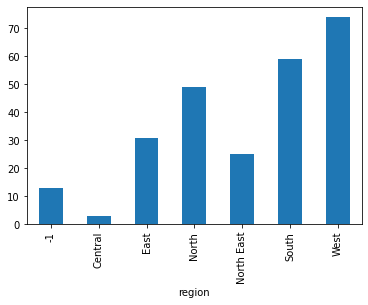

In [38]:
#a) Count of dishes across the different states of India

if_df.groupby('region')['name'].count().plot.bar()

array(['sweet', 'spicy', 'bitter', '-1', 'sour'], dtype=object)

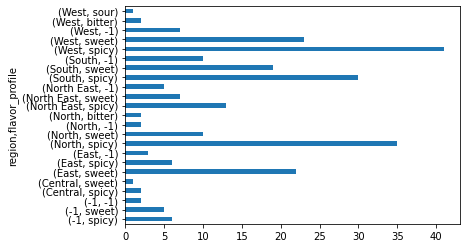

In [39]:
# b) Let's see how the flavor profile looks like for the different regions in India.

flavors_unique = if_df['flavor_profile'].unique()
display(flavors_unique)

region_flavors = if_df.groupby('region')['flavor_profile'].value_counts()

region_flavors.plot.barh(x='region', y='flavor_profile')
plt.show()


In [40]:
# c) What is the percentage distribution of Vegetarian and Non-Vegetarian dishes?

# if_df['diet'].value_counts()
#display(f"vegetarian dishes: {if_df.loc[if_df['diet']=='vegetarian']['name'].count()}\nnon-vegetarian dishes:{if_df.loc[if_df['diet']!='vegetarian']['name'].count()}")

print(f"vegetarian dishes: {if_df.loc[if_df['diet']=='vegetarian']['name'].count()}\nnon-vegetarian dishes:{if_df.loc[if_df['diet']!='vegetarian']['name'].count()}\nproportion non-vegetarian: {if_df.loc[if_df['diet']!='vegetarian']['name'].count()/if_df.loc[if_df['diet']=='vegetarian']['name'].count()}")



vegetarian dishes: 225
non-vegetarian dishes:29
proportion non-vegetarian: 0.1288888888888889


Text(0.5, 1.0, 'Non-vegetarian cook times')

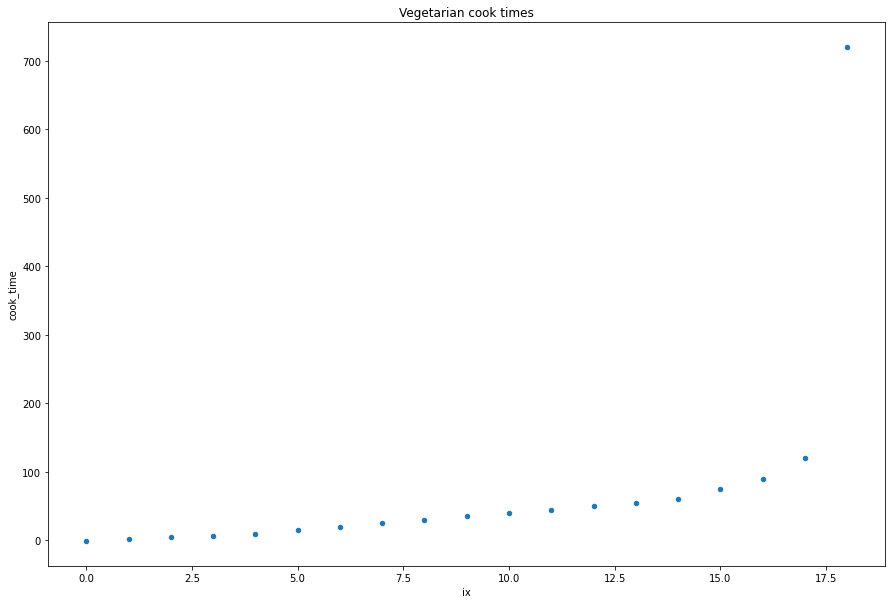

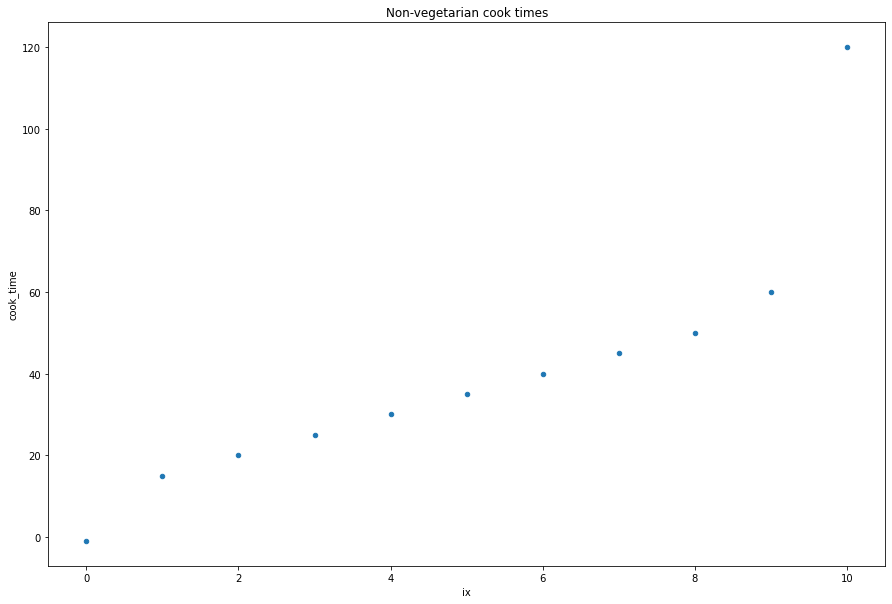

In [41]:
# d) Visualize the time required to cook the Vegetarian and Non-Vegetarian food items

def sort_scatter_on_val(df, col):
    s= pd.Series(df[col].unique()).sort_values()
    #s=s[:-1]
    s= s.reset_index()
    s= s.drop('index', axis=1) # drop original index
    s= s.reset_index()
    s.columns = ['ix', col]
    #display(s, type(s))
    return(
    s.plot.scatter(x='ix', y=col,figsize=(15,10))
    )


sort_scatter_on_val(if_df.loc[if_df['diet']=='vegetarian'],'cook_time')
plt.title(label='Vegetarian cook times')



sort_scatter_on_val(if_df.loc[if_df['diet']!='vegetarian'],'cook_time')
plt.title(label='Non-vegetarian cook times')


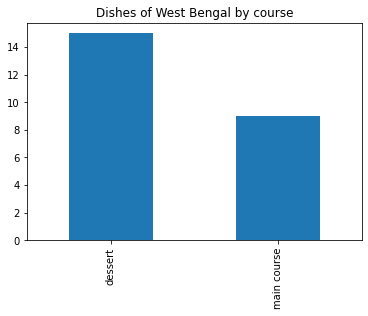

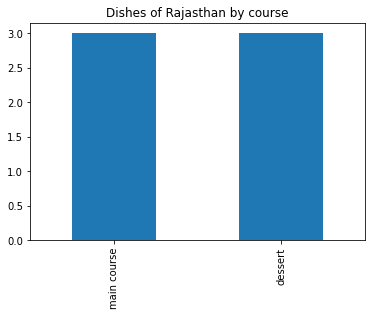

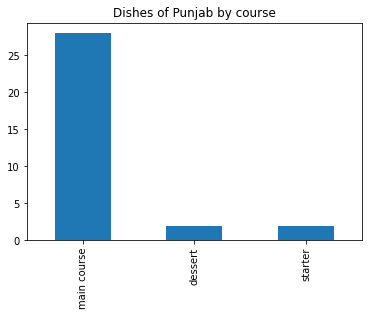

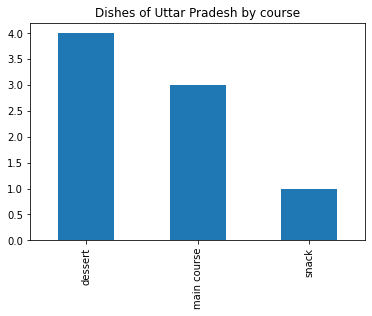

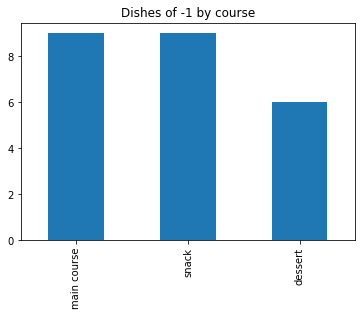

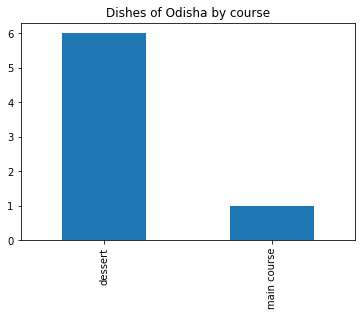

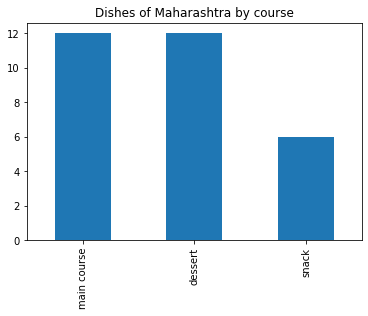

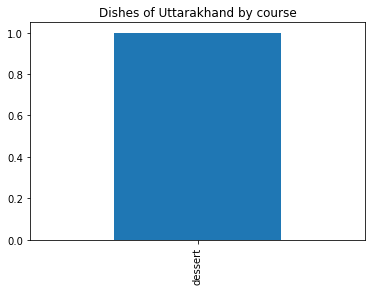

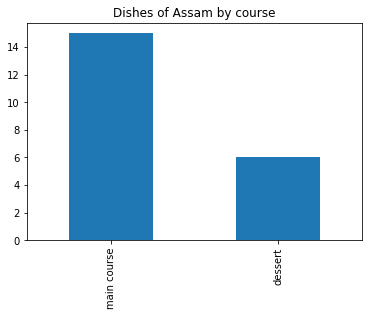

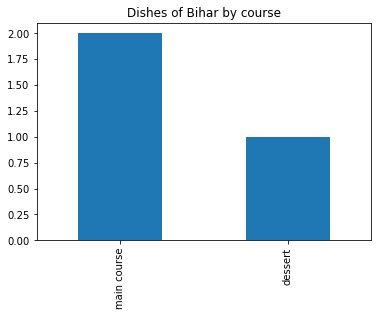

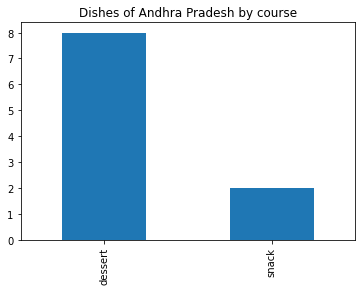

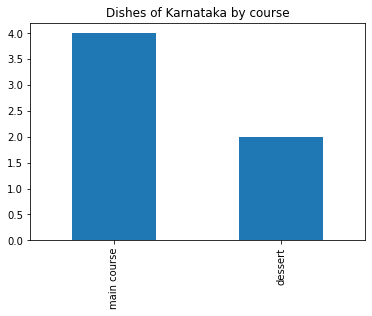

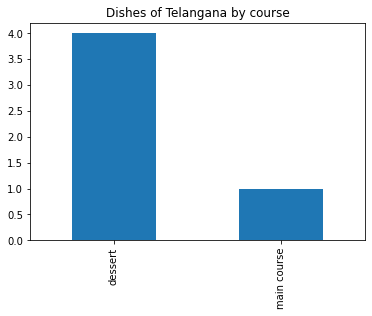

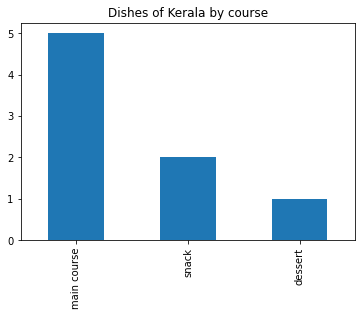

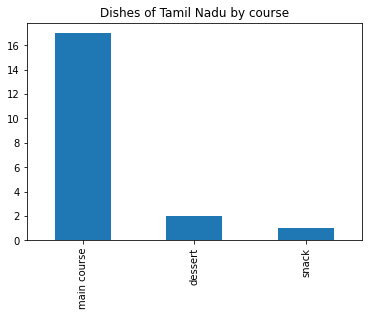

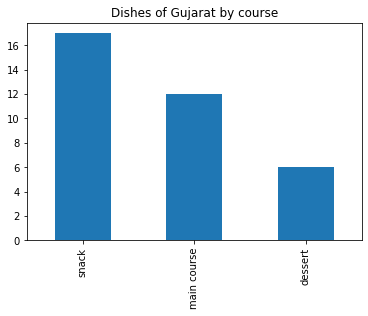

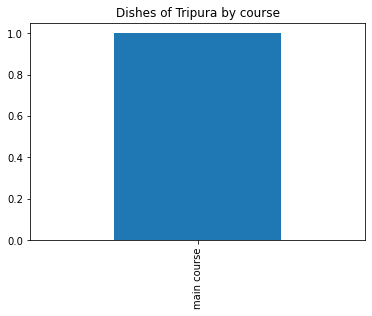

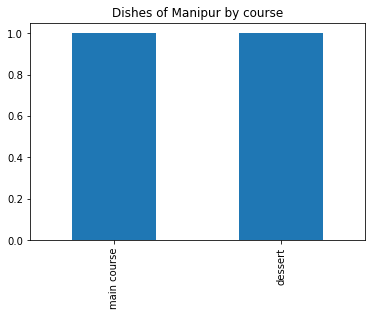

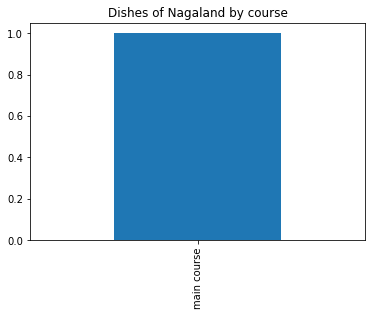

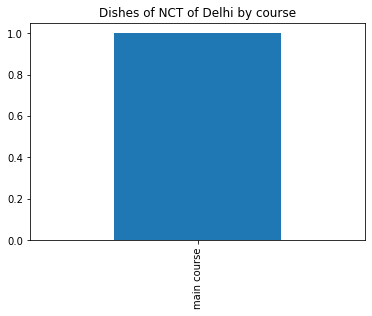

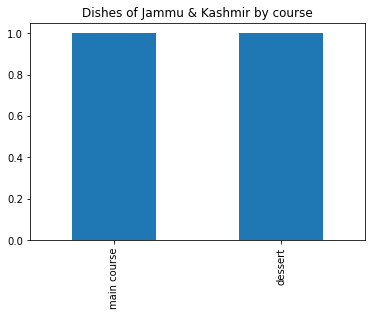

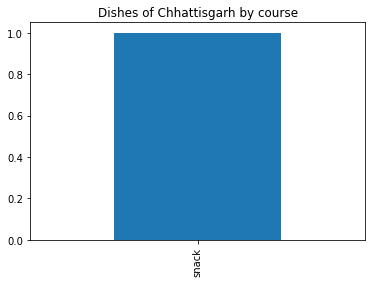

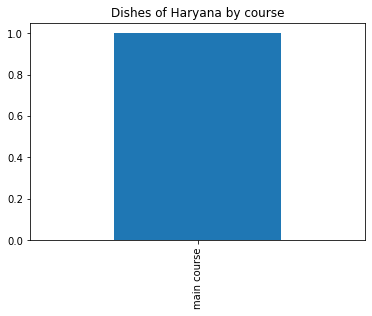

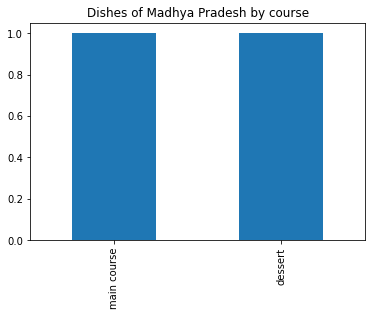

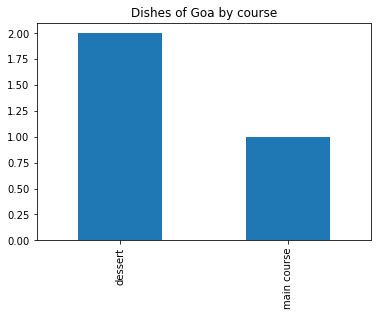

In [42]:
# e) What all courses do the food items belong to as per the different states
for _state in if_df['state'].unique():
    if_df.loc[(if_df['state']==_state)]['course'].value_counts().plot.bar()
    plt.title(label=f"Dishes of {_state} by course")
    plt.show()

In [52]:
# f) What are dishes with most ingredients?

most_ingredients_lst = if_df['ingredients_l'].apply(lambda l: (len(l), l))

most_ingredients_lst.sort_values(inplace=True, ascending=False)

display(list(zip(if_df.iloc[most_ingredients_lst[:10].index,:]['name'], [i[0] for i in most_ingredients_lst])))

[('Ghevar', 10),
 ('Jalebi', 9),
 ('Gulab jamun', 8),
 ('Mysore pak', 8),
 ('Obbattu holige', 7),
 ('Bandar laddu', 7),
 ('Theeyal', 6),
 ('Masor Koni', 6),
 ('Galho', 6),
 ('Nankhatai', 6)]

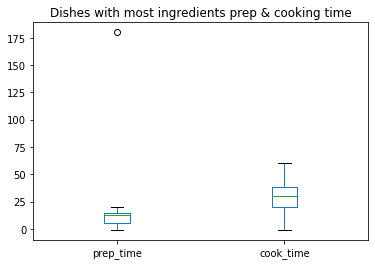

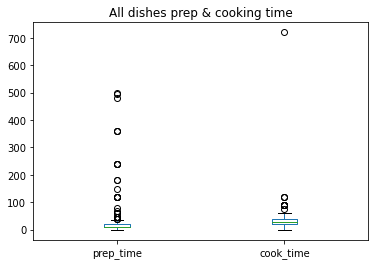

In [56]:
#g) Display Preparation Time and Cooking Time Distribution using Boxplot

if_df.iloc[most_ingredients_lst[:10].index,:].plot.box()
plt.title(label="Dishes with most ingredients prep & cooking time")
plt.show()

if_df.plot.box()
plt.title(label="All dishes prep & cooking time")
plt.show()


In [64]:
# h) Count state - wise dishes of each Zone

if_df.groupby('region')['state']

for _r in if_df['region'].unique():
    display('*****')
    display(if_df.loc[if_df['region']==_r].groupby('state')['name'].count())
#     display(if_df.loc[if_df['region']==_r].groupby('state')['name'].value_counts())
    


'*****'

state
Odisha          7
West Bengal    24
Name: name, dtype: int64

'*****'

state
Goa             3
Gujarat        35
Maharashtra    30
Rajasthan       6
Name: name, dtype: int64

'*****'

state
-1                  1
Bihar               3
Haryana             1
Jammu & Kashmir     2
NCT of Delhi        1
Punjab             32
Uttar Pradesh       8
Uttarakhand         1
Name: name, dtype: int64

'*****'

state
-1    13
Name: name, dtype: int64

'*****'

state
Assam       21
Manipur      2
Nagaland     1
Tripura      1
Name: name, dtype: int64

'*****'

state
-1                10
Andhra Pradesh    10
Karnataka          6
Kerala             8
Tamil Nadu        20
Telangana          5
Name: name, dtype: int64

'*****'

state
Chhattisgarh      1
Madhya Pradesh    2
Name: name, dtype: int64